## 1. Preprocessing cmc dataset

In [1]:
import sys
sys.path.append("..") # This will allow to fix import issues.[to be changed]

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tools import eda
from tools import preprocess as prep
from tools import all_steps

In [2]:
path = '../datasets/cmc.arff' # [to be changed]
df = eda.read_arff(path_data=path)

X_num, X_cat, y = all_steps.clean_cmc(df)

X = prep.join_features(X_num, X_cat)


# Samples before removing outliers: 1473
# Samples after removing outliers: 1455
Feature: weducation           | # categories: 4
Feature: heducation           | # categories: 3
Feature: wreligion            | # categories: 2
Feature: wworking             | # categories: 2
Feature: hoccupation          | # categories: 3
Feature: living_index         | # categories: 4
Feature: media_exposure       | # categories: 2

Binary cat_features: ['wreligion', 'wworking', 'media_exposure']
Remaining cat_features: ['weducation', 'heducation', 'hoccupation', 'living_index']
# Total features: 19


## 2. Analyze PCA

**Original plot**

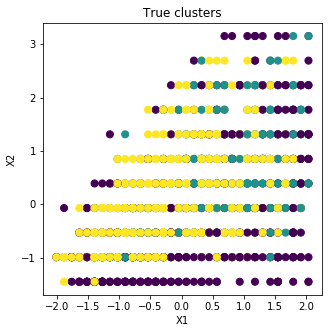

In [3]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X.values[:, 0], X.values[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('True clusters')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

**PCA plot**

In [4]:
from decomposition.pca import PCA

print(f'Shape X: {X.values.shape}')
# print(f'Shape W: {W.shape}')

pca = PCA(n_components=3, random_state=5)
X_pca = pca.fit_transform(X.values)

print(f'Shape X_pca: {X_pca.shape}')

Shape X: (1455, 19)
Shape X_pca: (1455, 3)


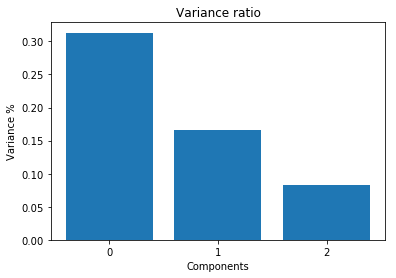

In [5]:
list_components = list(range(pca.n_components))
plt.bar(list_components, pca.explained_variance_ratio_)
plt.title('Variance ratio')
plt.xlabel('Components')
plt.ylabel('Variance %')
plt.xticks(list_components)
plt.show()

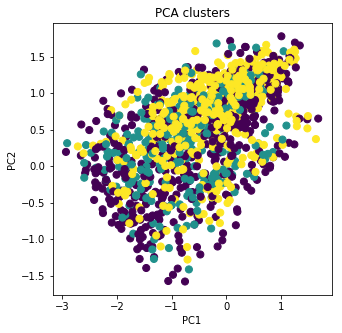

In [6]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('PCA clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**Reconstructed plot**

The reconstruction step share some how the borders of the original plot but the points inside the borders are distributed differently. This is because the reconstruction step is not perfect. It involves modify the values becacause of matrix operations. 

Shape X_reconstructed: (1455, 19)


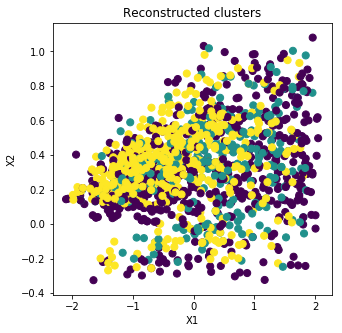

In [7]:
X_reconstructed = X_pca.dot(pca.W.T)
print(f'Shape X_reconstructed: {X_reconstructed.shape}')

fig = plt.figure(figsize=(5, 5))
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('Reconstructed clusters')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## 3. Analyze decomposition sklearn

The value of variance among the first three components seems similar to our implementation. Being the components about 30%, 15%, and 7% of importance, respectively, for both implementation.

The same occurs with IncrementalPCA.

### PCA

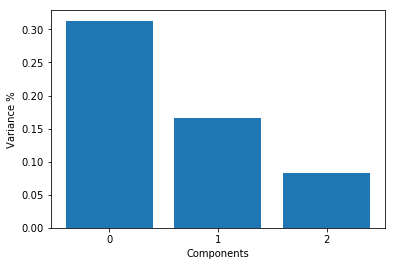

In [10]:
from tools.preprocess import graph_components
import sklearn

pca_sk = sklearn.decomposition.PCA(n_components=3, random_state=5)

X_pca_sk = pca_sk.fit_transform(X.values)

graph_components(X.values, n_components=3)


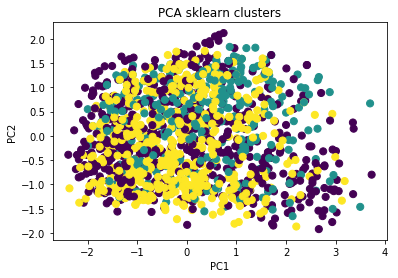

In [11]:
plt.scatter(X_pca_sk[:, 0], X_pca_sk[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('PCA sklearn clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### IncrementalPCA

Depending on the size of data, it can be faster than PCA.

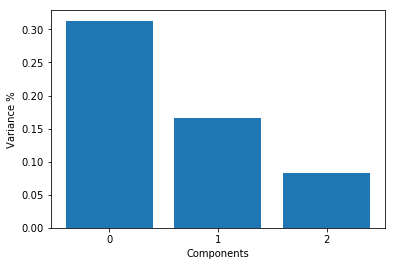

In [13]:
from tools.preprocess import graph_components
from sklearn.decomposition import PCA, IncrementalPCA

ipca = sklearn.decomposition.IncrementalPCA(n_components=3)

X_ipca_sk = ipca.fit_transform(X.values)

graph_components(X.values, n_components=3)


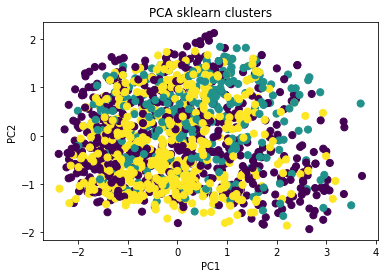

In [23]:
plt.scatter(X_ipca_sk[:, 0], X_ipca_sk[:, 1], c=y,
            s=50, cmap='viridis');
plt.title('PCA sklearn clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 4.   Use PCA and K-prototypes

We can see an improve in the metrics. The sillouete score has increased considerably. It means that separation of classes is more clear when applying PCA.

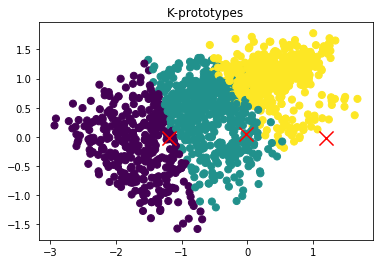

In [30]:
from cluster.kprototypes import KPrototypes

# cat_features = list(range(2, len(X.columns)))
kp = KPrototypes(n_clusters=3, cat_features=[], random_state=5)
kp.fit(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kp.labels,
            s=50, cmap='viridis');

centroids_pca = PCA(n_components=3).fit_transform(kp.centroids)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='x', c='r', s=200);
plt.title('K-prototypes')
plt.show()


**Metrics**

In [34]:
from cluster.metrics import get_metrics

get_metrics(y, kp.labels, X_pca, alg='kproto')

{'ars': 0.02176545437971874,
 'purity': 0.4343642611683849,
 'db': 1.2136284900264729,
 'f-measure': 0.30790378006872854,
 'silhouette': 0.31336180512954126}

**Previous metrics**

In [35]:
get_metrics(y, kp.labels, X, alg='kproto')

{'ars': 0.02176545437971874,
 'purity': 0.4343642611683849,
 'db': 2.811556640446925,
 'f-measure': 0.30790378006872854,
 'silhouette': 0.1114615170371232}

## 5. Use SOM to cluster

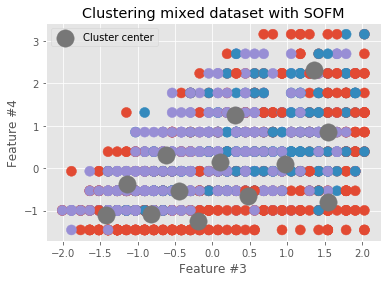

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from neupy import algorithms, utils


plt.style.use('ggplot')
utils.reproducible()



ggplot_colors = plt.rcParams['axes.prop_cycle']
colors = np.array([c['color'] for c in ggplot_colors])

# dataset = datasets.load_iris()
dataset = X.values
# use only two features in order
# to make visualization simpler
# data = dataset.data[:, [2, 3]]
data = dataset[:, [0, 1]]
# dataset = X_num_scaled.values
# target = dataset.target
target = y-1

sofm = algorithms.SOFM(
    # Use only two features for the input
    n_inputs=2,

    # Number of outputs defines number of features
    # in the SOFM or in terms of clustering - number
    # of clusters
    n_outputs=13,

    # In clustering application we will prefer that
    # clusters will be updated independently from each
    # other. For this reason we set up learning radius
    # equal to zero
    learning_radius=0,

    # Training step size or learning rate
    step=0.010,

    # Shuffles dataset before every training epoch.
    shuffle_data=True,

    # Instead of generating random weights
    # (features / cluster centers) SOFM will sample
    # them from the data. Which means that after
    # initialization step 3 random data samples will
    # become cluster centers
    weight='sample_from_data',

    # Shows training progress in terminal
    verbose=False,
)
sofm.train(data, epochs=50)

plt.title('Clustering mixed dataset with SOFM')
plt.xlabel('Feature #3')
plt.ylabel('Feature #4')

plt.scatter(*data.T, c=colors[target], s=100, alpha=1)
cluster_centers = plt.scatter(*sofm.weight, s=300, c=colors[3])

plt.legend([cluster_centers], ['Cluster center'], loc='upper left')
plt.show()